 apply "superstatistical" analysis ( https://www.nature.com/articles/ncomms8516#Sec19 ) to walking/crawling modes
 This is part two of the analysis where we will load the precomputed analysis

In [1]:
# paths
import pili
import sys, os
plot_target = os.path.normpath( os.path.join(pili.root, '../impress/paper_review/ims') )
print('plotting target', plot_target)
# control
detail = False
expensive = False



plotting target /home/dan/usb_twitching/impress/paper_review/ims


In [2]:
from copy import deepcopy
import numpy as np
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import plotutils
import twutils
import _fj
import matdef
from tqdm import tqdm
import shapeplot
import twanimation

In [3]:
# notebook control
expensive = False


In [4]:
# load fanjin data
debug = False
N = 100 if debug else None
# all_idx, trs = _fj.slicehelper.load_linearized_trs('all', N)
all_idx, trs = _fj.slicehelper.load_trs('all', N)
all_idx, ltrs = _fj.slicehelper.load_linearized_trs('all', N)
# numpy gets confused if we convert to numpy object array directly
all_trs = np.empty_like(all_idx, dtype=object)
all_ltrs = np.empty_like(all_idx, dtype=object)
for i, tr in enumerate(trs):
    all_trs[i] = tr
for i, ltr in enumerate(ltrs):
    all_ltrs[i] = ltr
crawling_idx = _fj.slicehelper.load('default_crawling_list')
walking_idx = _fj.slicehelper.load('default_walking_list')
crawling_trs = all_trs[crawling_idx]
walking_trs = all_trs[walking_idx]

combined_idx = np.concatenate([crawling_idx, walking_idx])
combined_trs = all_trs[combined_idx]

print()
print("loaded {} crawling tracks".format(crawling_idx.size))
print("loaded {} walking tracks".format(walking_idx.size))
print("total {} tracks".format(len(all_trs)))


100%|██████████| 3113/3113 [00:03<00:00, 992.06it/s] 

loaded 2505 crawling tracks
loaded 371 walking tracks
total 3113 tracks


In [5]:
# compute velocities
trackxy = [np.column_stack([ tr['x'], tr['y'] ]) for tr in all_trs]
# throw away the first velocity data point to keep shape with q, a
track_velocity = [((xy[1:] - xy[:-1])/matdef.TIMESTEP)[1:] for xy in trackxy]
track_speed = [np.sqrt(v[:,0]**2 + v[:,1]**2) for v in track_velocity]
mean_speed = np.array([np.mean(u) for u in track_speed])
var_speed = np.array([np.var(u) for u in track_speed])
base_whaspect = [tr['length']/tr['width'] for tr in all_trs]
# throw away first and last data points to keep shape with q, a
whaspect = [wh[1:-1] for wh in base_whaspect]

In [6]:
# compute velocities
lintrackxy = [np.column_stack([ tr['x'], tr['y'] ]) for tr in all_ltrs]
# throw away the first velocity data point to keep shape with q, a
lintrack_velocity = [((xy[1:] - xy[:-1])/matdef.TIMESTEP)[1:] for xy in lintrackxy]
lintrack_speed = [np.sqrt(v[:,0]**2 + v[:,1]**2) for v in lintrack_velocity]
lin_mean_speed = np.array([np.mean(u) for u in lintrack_speed])
print(np.nanmean(lin_mean_speed))


0.038009449991635726
/home/dan/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dan/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [7]:
# load precomputed analysis
precomputed_dir = 'persistance/data/fanjin'
a_form = 'avgPost_*'
b_form = 'postMean_*'
from glob import glob
def load_precomputed(datadir):
    a_lst = sorted(glob(os.path.join(datadir, a_form)))
    b_lst = sorted(glob(os.path.join(datadir, b_form)))
    avgPost = [np.load(a) for a in a_lst]
    postMean = [np.load(b) for b in b_lst]
    return avgPost, postMean
avgPost, postMean = load_precomputed(precomputed_dir)
print('compare shapes of each track data')
print('x', all_trs[0]['x'].shape)
print('v', track_velocity[0].shape)
print('q,a', postMean[0].shape)


compare shapes of each track data
x (2524,)
v (2522, 2)
q,a (2, 2522)


In [8]:
subsets = {}
subsets['all'] = all_idx
subsets['combined'] = combined_idx
subsets['crawling'] = crawling_idx
subsets['walking'] = walking_idx
for set_name, set_idx in subsets.items():
    print(set_name)
    print('mean speed', np.mean(mean_speed[set_idx]), 'mean variance', np.mean(var_speed[set_idx]))


all
mean speed 0.058097214007649514 mean variance 0.03000218856593431
combined
mean speed 0.053247990154890575 mean variance 0.026894406262577854
crawling
mean speed 0.028926741690165663 mean variance 0.008097313449293486
walking
mean speed 0.21746558423611936 mean variance 0.15381278226602083


In [9]:
# we should load the step analysis here as well right, so we can compare them if we want
# load step analysis
precomputed_dir = 'persistance/data/stepfj'
t_form = 'timebase_*'
a_form = 'avgPost_*'
b_form = 'postMean_*'
from glob import glob
def load_precomputed(datadir):
    a_lst = sorted(glob(os.path.join(datadir, a_form)))
    b_lst = sorted(glob(os.path.join(datadir, b_form)))
    print('found {} files with form {}'.format(len(a_lst), a_form))
    print('found {} files with form {}'.format(len(b_lst), b_form))
    avgPost = [np.load(a) for a in a_lst]
    postMean = [np.load(b) for b in b_lst]
    for i, p in enumerate(postMean):
        if p.size == 0:
            # need to regularise the non-data
            # should output this in clusterjob.py instead of just np.empty(0) 
            postMean[i] = np.array([np.empty(0), np.empty(0)])
    gshape = avgPost[0].shape
    gsize = avgPost[0].size
    for i, a in enumerate(avgPost):
        if a.size == 0:
            avgPost[i] = np.full(gshape, 1./gsize)
    return avgPost, postMean
step_avgPost, step_postMean = load_precomputed(precomputed_dir)
t_lst = sorted(glob(os.path.join(precomputed_dir, t_form)))
timebase = [np.load(t) for t in t_lst]
print('found {} files with form {}'.format(len(t_lst), t_form))
print('compare shapes of each track data')
print('x', all_trs[0]['x'].shape)
print('v', track_velocity[0].shape)
print('time', timebase[0].shape)
print('q,a', step_postMean[0].shape)


found 3113 files with form avgPost_*
found 3113 files with form postMean_*
found 3113 files with form timebase_*
compare shapes of each track data
x (2524,)
v (2522, 2)
time (38,)
q,a (2, 36)


In [10]:
# compute stats and correlation
step_q = [p[0] for p in step_postMean]
step_a = [p[1] for p in step_postMean]


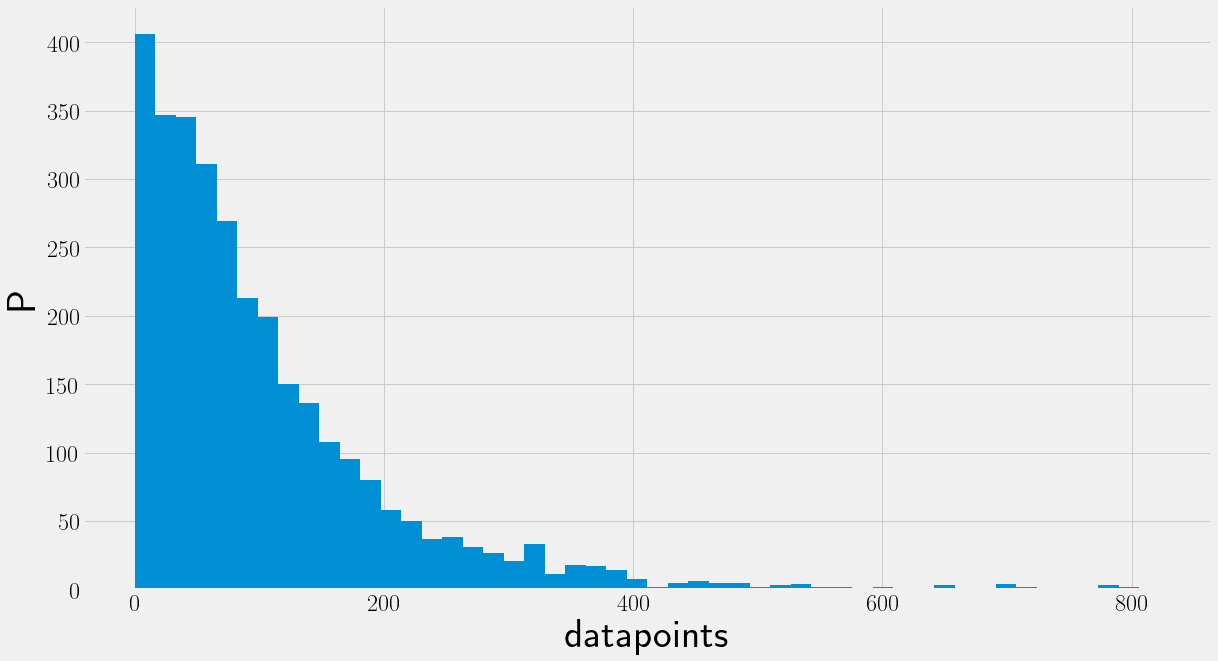

214 tracks with less than 10 datapoints
479 tracks with less than 20 datapoints
this is not the time to filter them because we want a fair comparison to the first analysis
but still min(data_size) is 0, empty arrays are going to mess up our code
64 tracks with less than 3 datapoints
remove them.


In [11]:
# we may have tracks with very low data now
data_threshold = 10
data_size = np.array([q.size for q in step_q])
plt.hist(data_size, bins=50, range=(0, np.quantile(data_size, 0.99)))
plt.xlabel('datapoints')
plt.ylabel('P')
plt.show()
low_data_idx = np.argwhere(data_size < data_threshold).ravel()
print('{} tracks with less than {} datapoints'.format(low_data_idx.size, data_threshold))
data_threshold = 20
low_data_idx = np.argwhere(data_size < data_threshold).ravel()
print('{} tracks with less than {} datapoints'.format(low_data_idx.size, data_threshold))
print('this is not the time to filter them because we want a fair comparison to the first analysis')
print('but still min(data_size) is 0, empty arrays are going to mess up our code')
# there is no nice way to deal with this. we can cut these tracks out of the subset object
data_threshold = 3
low_data_idx = np.argwhere(data_size <= data_threshold).ravel()
print('{} tracks with less than {} datapoints'.format(low_data_idx.size, data_threshold))
print('remove them.')

clean_subset = {}
def clean(set_idx):
    return np.array([idx for idx in set_idx if idx not in low_data_idx])
for set_name, set_idx in subsets.items():
    clean_subset[set_name] = clean(set_idx)



In [12]:
post_q = [p[0] for p in postMean]
post_a = [p[1] for p in postMean]

# replace with weighted mean
def track_statistics(post_q, post_a):
    qtrack = {}
    atrack = {}
    qtrack['mean'] = np.array([np.mean(track_q) for track_q in post_q])
    atrack['mean'] = np.array([np.mean(track_a) for track_a in post_a])
    qtrack['var'] = np.array([np.var(track_q) for track_q in post_q])
    atrack['var'] = np.array([np.var(track_a) for track_a in post_a])
    return qtrack, atrack
qtrack, atrack = track_statistics(post_q, post_a)



In [13]:
# correlation 
def corr_statistics(post_q, post_a, track_speed, whaspect, exclude=[]):
    corr = {}
    def corrab(a, b):
        coef = []
        for i, (t_a, t_q) in enumerate(zip(a,b)):
            coef.append(np.corrcoef(t_a, t_q)[0,1] if i not in exclude else np.nan)
        return np.array(coef)
        # return np.array([np.corrcoef(t_a, t_q)[0,1] for i, (t_a, t_q) in enumerate(zip(a,b)) if i not in exclude])
    corr['qa'] = corrab(post_q, post_a)
    corr['qu'] = corrab(post_q, track_speed)
    corr['au'] = corrab(post_a, track_speed)
    corr['qwh'] = corrab(post_q, whaspect)
    return corr
corr = corr_statistics(post_q, post_a, track_speed, whaspect)

print('mean p corr', np.mean(corr['qa']))
def quartiles(arr):
    return [np.quantile(arr, q) for q in [0, 0.25, 0.50, 0.75, 1.0]]
print('p corr quartiles', ' '.join(('{:6.4f}' for _ in range(5))).format(*quartiles(corr['qa'])))
# we might like to correlate persistance with aspect ratio


mean p corr -0.4162720320209257
p corr quartiles -0.9881 -0.5488 -0.4094 -0.2663 0.6344


In [14]:
# expensiive correlation functions
if expensive:
    qacorr = [np.correlate(track_q, track_a, mode='same') for track_q, track_a in 
        tqdm(zip(post_q, post_a))]


In [15]:
def summarise(subsets, qtrack, atrack, corr, acceptnan=False):
    mean = np.mean
    var = np.var
    if acceptnan:
        mean = np.nanmean
        var = np.nanvar
    for set_name, set_idx in subsets.items():
        print(set_name)
        mean_q = mean(qtrack['mean'][set_idx])
        mean_a = mean(atrack['mean'][set_idx])
        var_q = mean(qtrack['var'][set_idx])
        var_a = mean(atrack['var'][set_idx])
        prec = '{:5.4f}'
        print('mean q {:5.4f} mean a {:5.4f}, var q {:5.4f} var a {:5.4f}'.format( 
            mean_q, mean_a, var_q, var_a))
        # correlation functions
        print('corr qa' , mean(corr['qa'][set_idx]))
        print('corr qu' , mean(corr['qu'][set_idx]))
        print('corr au' , mean(corr['au'][set_idx]))
        print('corr q, aspect' , mean(corr['qwh'][set_idx]))
print('summarise whole track statistics')
# summarise(subsets, qtrack, atrack, corr)
summarise(clean_subset, qtrack, atrack, corr)

summarise whole track statistics
all
mean q 0.8747 mean a 0.0427, var q 0.0204 var a 0.0073
corr qa -0.421262365209815
corr qu -0.2339966728923137
corr au 0.6404346768447194
corr q, aspect 0.1604779648301038
combined
mean q 0.8771 mean a 0.0408, var q 0.0204 var a 0.0069
corr qa -0.41660557407829624
corr qu -0.23387051804341952
corr au 0.6402905611678573
corr q, aspect 0.16333467441701974
crawling
mean q 0.9272 mean a 0.0234, var q 0.0074 var a 0.0021
corr qa -0.3960613203419763
corr qu -0.22380614476670993
corr au 0.6399942587736266
corr q, aspect 0.10733629843767298
walking
mean q 0.5443 mean a 0.1564, var q 0.1067 var a 0.0388
corr qa -0.5530661862943405
corr qu -0.3007208673692058
corr au 0.6422586835750643
corr q, aspect 0.5352913668977213


saving to  /home/dan/usb_twitching/impress/paper_review/ims/velocity_box.png


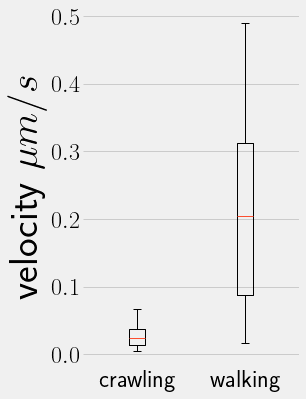

In [16]:
# compare crawling / walking 
# presentation quality plots
prop_cycle = plt.rcParams['axes.prop_cycle']
defcolors = prop_cycle.by_key()['color']
# velocity bar chart
def box_plot_velocity(mean_speed, subsets):
    fig = plt.figure(figsize=(3,5))
    ax = fig.add_axes([0,0,1,1])
    kw = {'whis':(5,95), 'showfliers':False}
    ax.boxplot([mean_speed[subsets['crawling']], mean_speed[subsets['walking']]], **kw)
    ax.set_ylabel(r'velocity $\mu m/s$')
    ax.set_xticklabels(['crawling', 'walking'])
    ax.grid(axis='x')
    for d in ['top', 'bottom', 'right', 'left']:
        ax.spines[d].set_visible(False)
    return fig

fig = box_plot_velocity(mean_speed, clean_subset)
savefile = os.path.join(plot_target, 'velocity_box.png')
print('saving to ', savefile)
fig.savefig(savefile, bbox_inches='tight', facecolor='white')



<ipython-input-17-8a1b04a4776b>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(boxnames + boxnames)
saving to  /home/dan/usb_twitching/impress/paper_review/ims/statistics_box.png


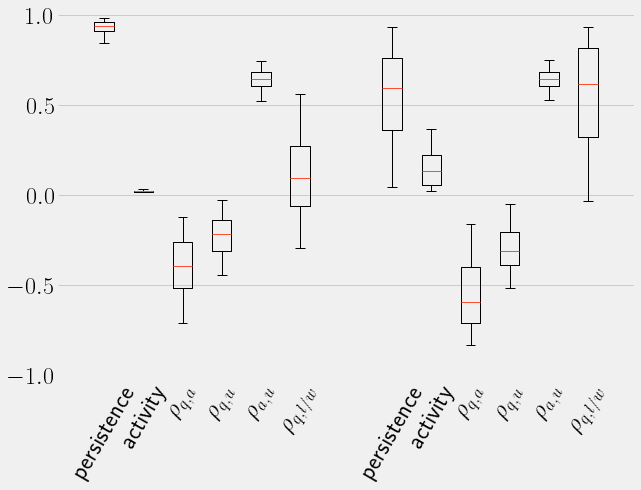

In [17]:
# correlation function boxplot

def box_plot_statistics(qtrack, atrack, corr, subsets):
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_axes([0,0,1,1])
    offset = 0.08
    boxnames = ['persistence', 'activity', r'$\rho_{q,a}$', r'$\rho_{q,u}$', r'$\rho_{a,u}$']
    boxnames.append(r'$\rho_{q,l/w}$')
    n = len(boxnames)
    positions = np.concatenate([np.linspace(offset, 0.5-offset, n), np.linspace(0.5+offset, 1.0-offset, n)])
    width = (positions[1] - positions[0])/2
    vectors = []
    for name in ['crawling', 'walking']:
        set_idx = subsets[name]
        vectors.append(qtrack['mean'][set_idx])
        vectors.append(atrack['mean'][set_idx])
        vectors.append(corr['qa'][set_idx])
        vectors.append(corr['qu'][set_idx])
        vectors.append(corr['au'][set_idx])
        vectors.append(corr['qwh'][set_idx])

    ax.set_xticklabels(boxnames + boxnames)
    for tick in ax.get_xticklabels():
        tick.set_rotation(60)

    for tick in ax.get_xaxis().get_major_ticks():
        tick.set_pad(8.)

    kw = {'whis':(5,95), 'showfliers':False}
    ax.boxplot(vectors, positions=positions, widths=width, **kw)
    ax.set_xlim((0,1))
    ax.set_ylim((-1,1))
    ax.grid(axis='x')

    for d in ['top', 'bottom', 'right', 'left']:
        ax.spines[d].set_visible(False)
    return fig

fig = box_plot_statistics(qtrack, atrack, corr, clean_subset)
savefile = os.path.join(plot_target, 'statistics_box.png')
print('saving to ', savefile)
fig.savefig(savefile, bbox_inches='tight')




In [18]:

step_idx = [track.step_idx for track in all_ltrs]
step_velocity = [track.get_step_velocity() for track in all_ltrs]
step_dt = [track.get_step_dt() for track in all_ltrs]
step_speed_base = [np.sqrt(v[:,0]**2 + v[:,1]**2) for v in step_velocity]
step_speed = [s[1:] for s in step_speed_base]
step_whaspect_base = [wh[s_idx] for s_idx, wh in zip(step_idx, base_whaspect)]
step_whaspect = [wh[1:-1] for wh in step_whaspect_base]
# check shapes
shapes = [step_whaspect[0].shape, step_speed[0].shape , step_q[0].shape ]
assert(all([shapes[0] == x for x in shapes]) )
#
def step_track_statistics(a_post):
    # not means
    qtrack = {}
    atrack = {}
    qt = []
    at = []
    for avgPost in a_post:
        gridSize = 200
        aBound = [0,3.0]
        qBound = [-1.5, 1.5]
        qGrid  = (np.array([np.linspace(qBound[0], qBound[1], gridSize+2)[1:-1]]*gridSize)).T
        aGrid  = (np.array([np.linspace(aBound[0], aBound[1], gridSize+2)[1:-1]]*gridSize))
        # not a mean
        qt.append(np.sum(qGrid*avgPost))
        at.append(np.sum(aGrid*avgPost))
    # not a mean
    qtrack['mean'] = np.array(qt)
    atrack['mean'] = np.array(at)
    return qtrack, atrack

# step_qtrack, step_atrack = step_track_statistics(step_q, step_a)
step_qtrack, step_atrack = step_track_statistics(step_avgPost)
step_corr = corr_statistics(step_q, step_a, step_speed, step_whaspect, exclude=low_data_idx)

In [19]:
# check for nan
not_low_data_idx  = np.array([i for i in all_idx if i not in low_data_idx])
print(low_data_idx.size)
print(not_low_data_idx.size)
qnan = np.count_nonzero(np.isnan(step_qtrack['mean']))
anan = np.count_nonzero(np.isnan(step_atrack['mean']))
unan = np.count_nonzero(np.isnan([np.mean(u) for u in step_speed]))
print('counting nan data, (q,a,u)', qnan, anan, unan )



64
3049
counting nan data, (q,a,u) 0 0 16
/home/dan/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dan/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [20]:
print('summarise step track statistics')
# summarise(clean_subset, step_qtrack, step_atrack, step_corr, acceptnan=True)

summarise step track statistics


mean speed 0.03813513291341589
[]
[[0], [0], [0], [0], [0], [0]]
median speed 0.027740211618005394
stepped median speed 0.019559821527284776
<ipython-input-21-0d4184fd9a33>:3: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(w*b)/np.sum(w)


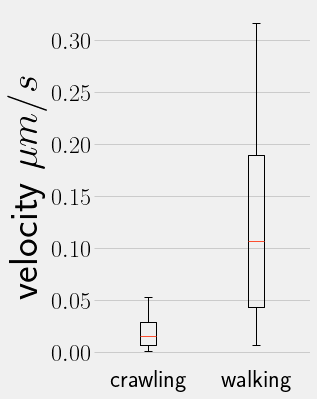

In [21]:
# velocity box plot
def wmean(w,b):
    return np.sum(w*b)/np.sum(w)
step_mean_speed = np.array([wmean(dt,speed) for dt,speed in zip(step_dt,step_speed_base)])
print('mean speed', np.nanmean(step_mean_speed))
print(np.argwhere(np.isnan(step_mean_speed[clean_subset['crawling']])))
# step_mean_speed[np.isnan(step_mean_speed)] = 0
# print(np.argwhere(np.isnan(step_mean_speed)))
print([step_idx[i] for i in np.nonzero(np.isnan(step_mean_speed))[0]])
fig = box_plot_velocity(step_mean_speed, clean_subset)

print('median speed' ,np.median(mean_speed[clean_subset['all']]))
print('stepped median speed', np.median(step_mean_speed[clean_subset['all']]))


<ipython-input-17-8a1b04a4776b>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(boxnames + boxnames)


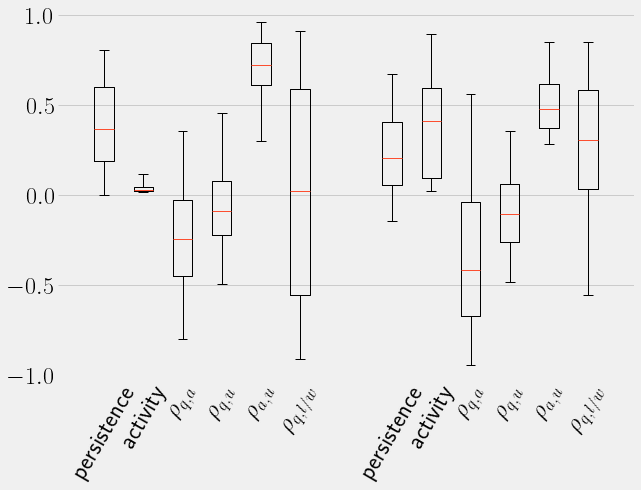

In [22]:

# wrong means!
# need to recompute using either postSequ[-1] or MLE
fig = box_plot_statistics(step_qtrack, step_atrack, step_corr, clean_subset)
# savefile = os.path.join(plot_target, 'step_statistics_box.png')
# print('saving to ', savefile)
# fig.savefig(savefile, bbox_inches='tight')



original q distribution


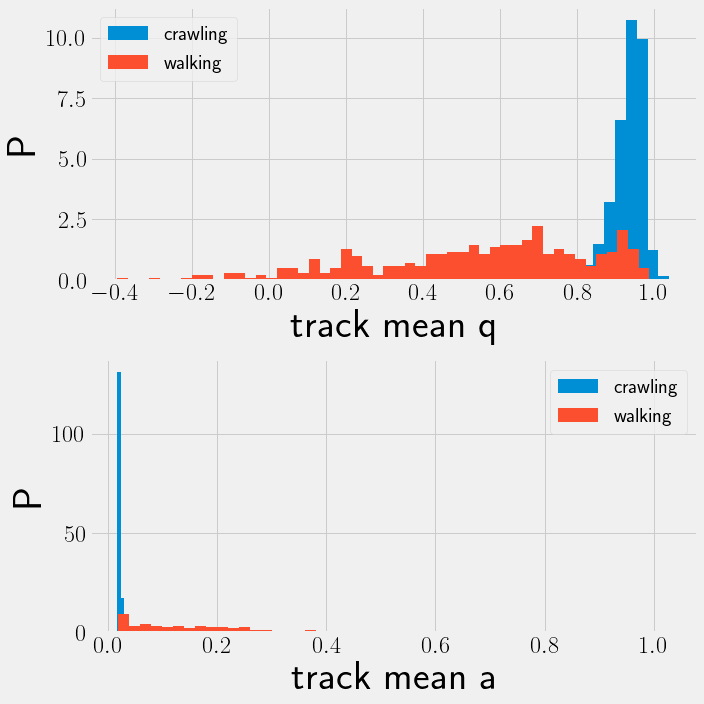

In [23]:
# lets compare the q distributions
clean_crawling = clean_subset['crawling']
clean_walking = clean_subset['walking']
# print(np.var(qtrack['var'][clean_crawling]), np.nanvar(step_qtrack['var'][clean_crawling]))
# 
print('original q distribution')
fig, axes = plt.subplots(2,1, figsize=(10,2*5))
ax = axes[0]
hstyle = {'density':True, 'bins':50}
ax.hist(qtrack['mean'][subsets['crawling']], label='crawling', **hstyle)
ax.hist(qtrack['mean'][subsets['walking']], label='walking', **hstyle)
ax.set_xlabel('track mean q')
ax.set_ylabel('P')
ax.legend()
ax = axes[1]
ax.hist(atrack['mean'][subsets['crawling']], label='crawling', **hstyle)
ax.hist(atrack['mean'][subsets['walking']], label='walking', **hstyle)
ax.set_xlabel('track mean a')
ax.set_ylabel('P')
ax.legend()
plt.tight_layout()
plt.show()
# todo are these going to separate if we cut out the slow tracks and maybe the mischaracterised walking tracks?


step q distribution


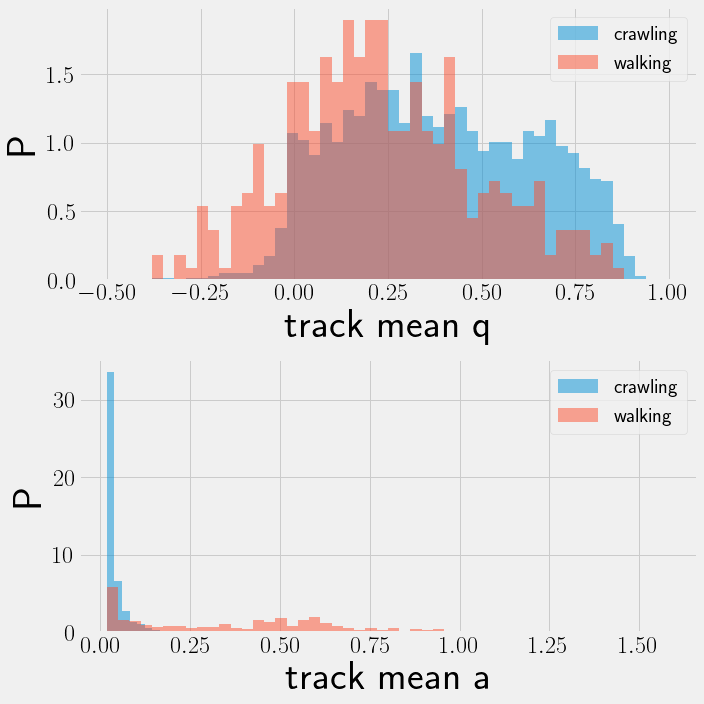

In [24]:
print('step q distribution')
fig, axes = plt.subplots(2,1, figsize=(10,2*5))
ax = axes[0]
hstyle = {'density':True, 'bins':50, 'alpha':0.5, 'range':(-0.5,1.0)}
ax.hist(step_qtrack['mean'][clean_subset['crawling']], label='crawling', **hstyle)
ax.hist(step_qtrack['mean'][clean_subset['walking']], label='walking', **hstyle)
ax.set_xlabel('track mean q')
ax.set_ylabel('P')
ax.legend()
ax = axes[1]
hstyle = {'density':True, 'bins':50, 'alpha':0.5}
ax.hist(step_atrack['mean'][clean_subset['crawling']], label='crawling', **hstyle)
ax.hist(step_atrack['mean'][clean_subset['walking']], label='walking', **hstyle)
ax.set_xlabel('track mean a')
ax.set_ylabel('P')
ax.legend()
plt.tight_layout()
plt.show()

 so the 'true' persistance indicates that our population in fact has a wide range of persistant behaviour
 high persistance tracks in walking set are most likely mischaracterised ....
 Are low persistance tracks in crawling set just not really moving anywhere?

747
479


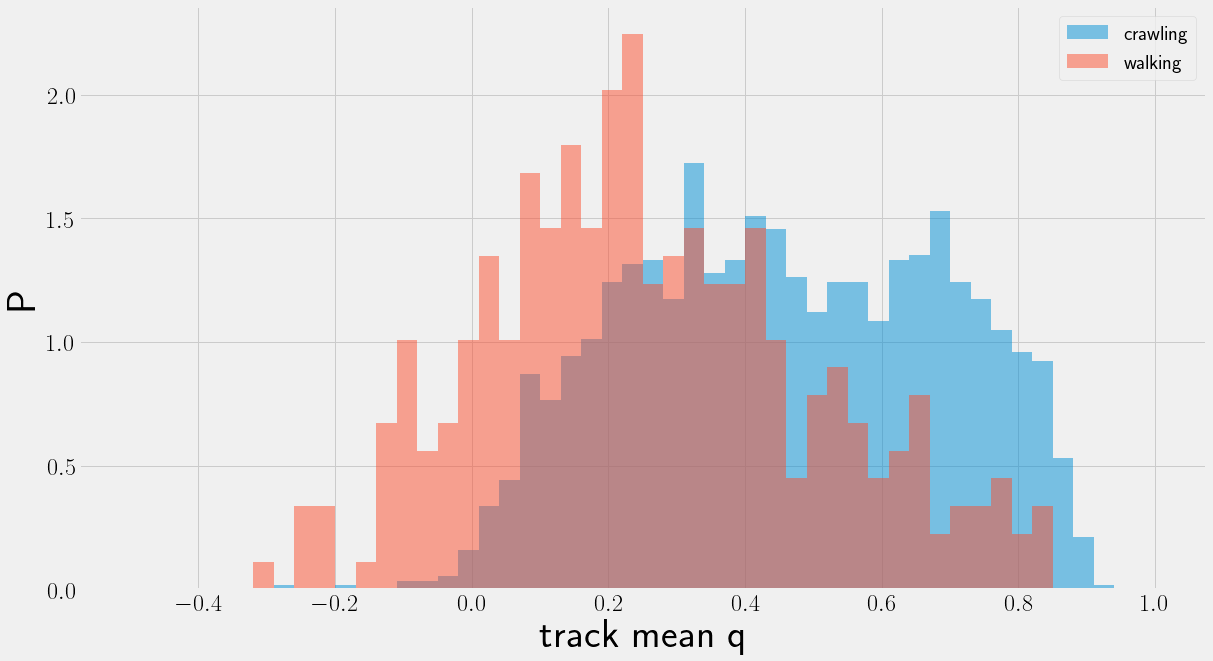

In [25]:
# if we do some filtering do these distributions separate?
data_threshold = 20
low_data_idx = np.argwhere(data_size < data_threshold).ravel()
low_displacement_idx = _fj.slicehelper.load('low_displacement_outliers')
print(low_displacement_idx.size)
print(low_data_idx.size)
to_filter_idx = np.union1d(low_data_idx, low_displacement_idx)
filter_subset = {k: np.copy(v) for k, v in clean_subset.items()}
for k ,v in filter_subset.items():
    filter_subset[k] = np.array([idx for idx in v if idx not in to_filter_idx]) 
ax = plt.gca()
hstyle = {'density':True, 'bins':50, 'alpha':0.5, 'range':(-0.5,1.0)}
ax.hist(step_qtrack['mean'][filter_subset['crawling']], label='crawling', **hstyle)
ax.hist(step_qtrack['mean'][filter_subset['walking']], label='walking', **hstyle)
ax.set_xlabel('track mean q')
ax.set_ylabel('P')
ax.legend()


 going to this line of investigation here and say that better filtering is not going to change the outcome.
 course grained tarjecty q values overlap between walking and crawling because
 the linearization is a type of coarse graining and thats if perfectly consistent with the results.

In [26]:
# check how many have positive q,a correlation
pos_qa_corr_idx = np.argwhere(corr['qa'] > 0).ravel()
print('{} tracks with positive qa corr'.format(pos_qa_corr_idx.size))
sorted(list(zip(pos_qa_corr_idx, corr['qa'][pos_qa_corr_idx])), key=lambda t:t[1], reverse=True)
# todo, can plot outliers

12 tracks with positive qa corr


[(686, 0.6343727956121903),
 (466, 0.510834449494545),
 (491, 0.2849187101532565),
 (34, 0.2774807903730617),
 (2646, 0.23342068064106844),
 (1051, 0.1356987520253956),
 (2707, 0.1014737927515239),
 (1688, 0.08014342034056025),
 (2736, 0.07139759458940266),
 (1998, 0.06469630632730967),
 (650, 0.05998368550188688),
 (2142, 0.01809479543690007)]

In [27]:
# check how many have negative q, aspect correlation
print('q, aspect, quartiles ', quartiles(corr['qwh']))
# about 25%
neg_qwh_corr_idx = np.argwhere(corr['qwh'] < 0).ravel()
print('{} tracks have negative q, aspect correlation'.format(neg_qwh_corr_idx.size))
# plt.hist( corr['qwh'][neg_qwh_corr_idx] )
# plt.show()

# maybe we can filter them using our outlier analysis first and then plot?
# this must include a lot of crawling tracks which have low variance in aspect ratio
# how to specifically get tracks with high correlation between angle and persistance?
# for now lets just check the walking set
inters = np.intersect1d(walking_idx, neg_qwh_corr_idx)
outliers = sorted(list(zip(inters, corr['qwh'][inters])), key=lambda t:t[1])
print('only {} walkers with negative q, aspect correlation'.format(inters.size))
sorted_idx = np.array([p[0] for p in outliers])
# print('speeds')
# which is fast if we compare to the mean for walking
walking_speed = np.mean(mean_speed[walking_idx])
relative_speed = mean_speed[sorted_idx]/walking_speed
# print(relative_speed)
print('the candidate tracks are ', sorted_idx)
# which we can now plot with shapeplot?


q, aspect, quartiles  [-0.8418951705433968, -0.04565910262331366, 0.12637314674581251, 0.32860800690129033, 0.98677672105661]
979 tracks have negative q, aspect correlation
only 27 walkers with negative q, aspect correlation
the candidate tracks are  [ 168 2601 1936 2189 1641 2840  491  788 1642 2007 2205   34 2011  259
 1937 1923  174 1920 2085  465   99  155  545   35  349   72 2258]


In [28]:
# and because there are 27 tracks lets write them to persistence/data/persitent_walker
outdir = 'persistance/data/persitent_walker'
if not os.path.exists(outdir):
    os.mkdir(outdir)

if expensive:
    outform = os.path.join(outdir, 'drawtrack_{:04d}.png')
    for idx in sorted_idx:
        track = all_trs[idx]
        fig, ax = plt.subplots(1,1)
        print(ax)
        shapeplot.ltdraw(ax, [track], sample=100)
        out = outform.format(idx)
        print('saving to ', out)

        plt.savefig(out)
    plt.close()


In [29]:
if expensive:
    to_animate = [788, 2007, 2085, 2258]
    for idx in to_animate:
        savefile = 'plots/animate_outline_{:04d}.mp4'.format(idx)
        track = all_trs[idx]
        print()
        print('animating track {} and saving at {}'.format(idx, savefile))
        twanimation.outline(plt.gcf(), [track], sample=10, savefile=savefile)
        plt.clf()

 And I think its safe to say none of these tracks have the persistent walking behaviour

100%|██████████| 1/1 [00:00<00:00, 340.78it/s]
data size 2080
track size (270, 2)



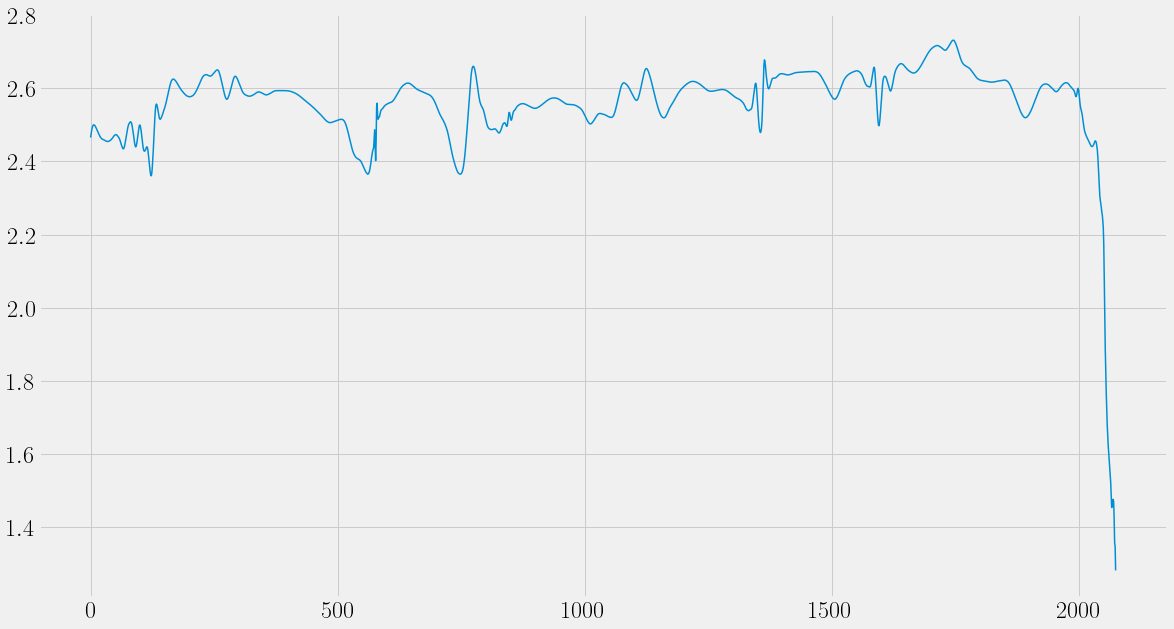

In [30]:
fast_crawling_id = 2924
# we want to check that we can set pmin=0 and maybe R=0 for crawling data
fctrack = _fj.trackload([fast_crawling_id])[0]
fclin = _fj.lintrackload([fast_crawling_id])[0]
step_velocity = fclin.get_step_velocity()
print()
print('data size', fctrack['time'].size)
print('track size', step_velocity.shape)
aspect = fclin.get_aspect()
plt.plot(aspect)
plt.show()

In [31]:
sys.path.insert(0, os.path.abspath('tools/'))
import bayesloop
simple_analyser = bayesloop.BayesLoop()
simple_analyser.pMin = 0
simple_analyser.Ra = 0
simple_analyser.Rq = 0
simple_analyser.set_aBound((0,2.0))
simple_analyser.set_qBound((-1,1))

print('boundaries', simple_analyser.boundaries)

simple_analyser.data = step_velocity
simple_analyser.startAnalysis()

boundaries [0, 2.0, -1, 1]
build parameter grid...
Computing posterior sequence in both directions...
Computing posterior mean values...
Finished Analysis...


In [32]:
# confidence interval from bayesian method 
postMean, avgPost = simple_analyser.postMean, simple_analyser.avgPost
qGrid, aGrid = simple_analyser.qGrid, simple_analyser.aGrid
post = simple_analyser.postSequ[-1]
q_post = post.sum(axis=1)
plt.plot(q_post)
import scipy.integrate
q_sum = scipy.integrate.cumulative_trapezoid(q_post)

ci_i = (np.searchsorted(q_sum,0.025), np.searchsorted(q_sum,0.975,'right'))
bayesian_ci = list(qGrid[i,0] for i in ci_i)
q_estimate = np.sum(simple_analyser.postSequ[-1])
print(bayesian_ci)
plt.plot(q_sum)
plt.close()


[0.691542288557214, 0.8009950248756219]


In [33]:
simple_analyser.use_reverse = False
simple_analyser.startAnalysis()
postMean, avgPost = simple_analyser.postMean, simple_analyser.avgPost
qGrid, aGrid = simple_analyser.qGrid, simple_analyser.aGrid

post = simple_analyser.postSequ[-1]
q_post = post.sum(axis=1)
a_post = post.sum(axis=0)
def compute_bayesian_ci(p_param, Grid):
    # bayesian ci on grid
    _sum = scipy.integrate.cumulative_trapezoid(p_param)
    ci_i = (np.searchsorted(_sum,0.025), np.searchsorted(_sum,0.975,'right'))
    bayesian_ci = list(Grid[i,0] for i in ci_i)
    return bayesian_ci
bayesian_ci_q = compute_bayesian_ci(q_post, qGrid)
bayesian_ci_a = compute_bayesian_ci(a_post, aGrid.T)
amin, amax, qmin, qmax = simple_analyser.boundaries
a_step = (amax - amin)/simple_analyser.gridSize
print('grid step in a dimension', a_step)

postMean, avgPost = simple_analyser.postMean, simple_analyser.avgPost
qGrid, aGrid = simple_analyser.qGrid, simple_analyser.aGrid
post = simple_analyser.postSequ[-1]
q =  np.sum(post*qGrid)
a =  np.sum(post*aGrid)
print('bayesian expected values {:5.4f} {:5.4f}'.format(q,a))
confidence_form = '[{:5.4f},{:5.4f}]'
print('bayesian confidence {}'.format(confidence_form.format(*bayesian_ci_q)))
print('bayesian confidence {}'.format(confidence_form.format(*bayesian_ci_a)))
# the confidence interval for a is approximately +/- one grid point which should be the minimum


build parameter grid...
Computing posterior sequence...
Computing posterior mean values...
Finished Analysis...
grid step in a dimension 0.01
bayesian expected values 0.7522 0.1275
bayesian confidence [0.6915,0.8010]
bayesian confidence [0.1095,0.1294]


In [34]:
# try MLE (see Metzner, supplimentary)
def q_estimator(u_t,u_p, sample=None):
    if sample is None:
        sample = np.array(range(u_t.shape[0]))
    return np.sum( (u_t*u_p).sum(axis=1)[sample] )/np.sum( (u_p*u_p).sum(axis=1)[sample] )
def mle(u_t,u_p, sample=None):
    if sample is None:
        sample = np.array(range(u_t.shape[0]))
    qhat = q_estimator(u_t,u_p, sample)
    upart = (u_t - qhat*u_p)[sample]
    return qhat, np.sqrt(np.sum(upart*upart)/(2*(u_t.shape[0])))

qhat, ahat = simple_analyser.MLE()
print('MLE estimates {:5.4f}, {:5.4f}'.format(qhat, ahat))

MLE estimates 0.7522, 0.1261


In [35]:
# bootstrap method 
N = 1
N = 10000
usize = simple_analyser.data.shape[0]
bootstrap_q = []
bootstrap_a = []
u = simple_analyser.data

for _ in range(N):
    choice = np.random.choice(usize-1,usize-1,replace=True)
    _qhat, _ahat = mle(u[1:],u[:-1], choice)
    bootstrap_q.append(_qhat)
    bootstrap_a.append(_ahat)
print('limits', np.min(bootstrap_q), np.max(bootstrap_q))
print('bootstrap (mean,std) ', np.mean(bootstrap_q), np.std(bootstrap_q))
import scipy.stats
print('(skew, kurtosis) ', scipy.stats.skew(bootstrap_q),scipy.stats.kurtosis(bootstrap_q))
# condifdence interval
bootstrap_ci_q = np.quantile(bootstrap_q,0.025), np.quantile(bootstrap_q,0.975)
bootstrap_ci_a = np.quantile(bootstrap_a,0.025), np.quantile(bootstrap_a,0.975)
print('bootstrap ci_q {}'.format(confidence_form.format(*bootstrap_ci_q)))
print('bootstrap ci_a {}'.format(confidence_form.format(*bootstrap_ci_a)))
# so the bootstrap confidence interval is a little larger than the bayesian one


limits 0.6176920978012199 0.9332896187767556
bootstrap (mean,std)  0.7560815953614638 0.04478846999834357
(skew, kurtosis)  0.2645106920341546 0.058221728741841616
bootstrap ci_q [0.6746,0.8485]
bootstrap ci_a [0.1041,0.1553]


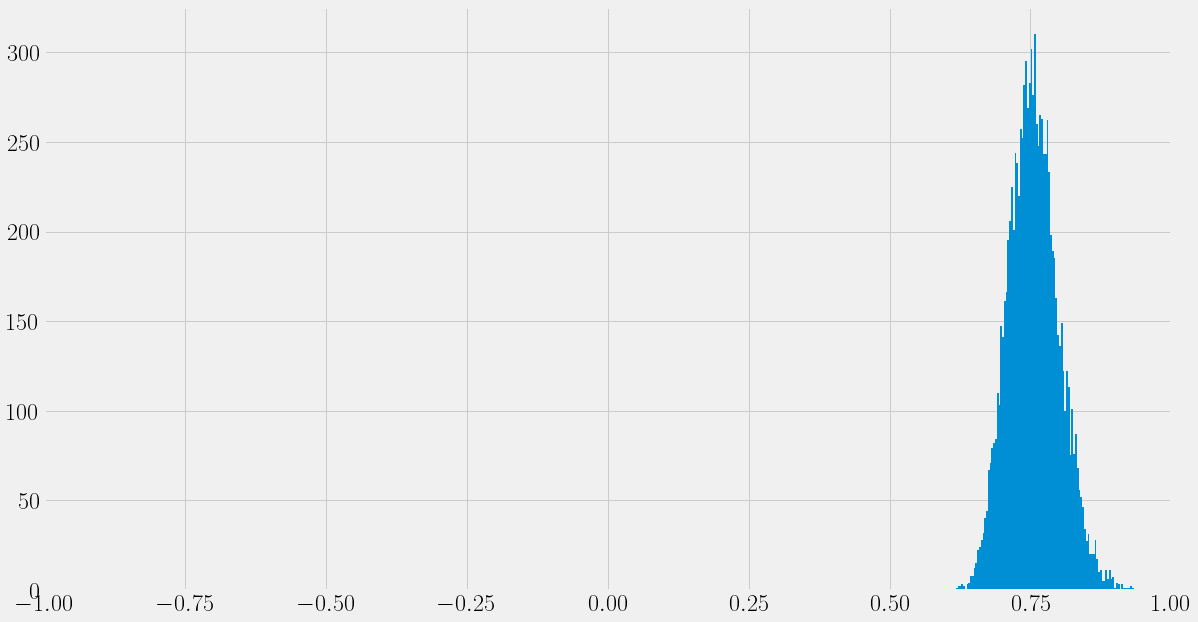

In [36]:
ax = plt.gca()
ax.hist(bootstrap_q, bins=100)
ax.set_xlim(-1,1)
plt.show()


In [37]:
# fisher information // observed information
u = simple_analyser.data

def fisher_information(u_t, u_p, qhat, ahat):
    n = u_t.shape[0]
    qq = np.sum( (u_p*u_p).sum(1) )/ahat**2
    _num = u_t - qhat*u_p
    aa = 3*np.sum(_num*_num)/ahat**4 - 2*(n-1)/ahat**2
    return qq, aa
observed_qq, observed_aa = fisher_information(u[1:],u[:-1],qhat,ahat)
print('observed information', observed_qq, observed_aa)

err = 1.96/np.sqrt(observed_qq)
fisher_ci_q = (qhat-err, qhat+err)
err = 1.96/np.sqrt(observed_aa)
fisher_ci_a = (ahat-err, ahat+err)
print('fisher interval q {}'.format(confidence_form.format(*fisher_ci_q)))
print('fisher interval a {}'.format(confidence_form.format(*fisher_ci_a)))



observed information 1270.5057674958 67790.46680883766
fisher interval q [0.6972,0.8072]
fisher interval a [0.1186,0.1336]


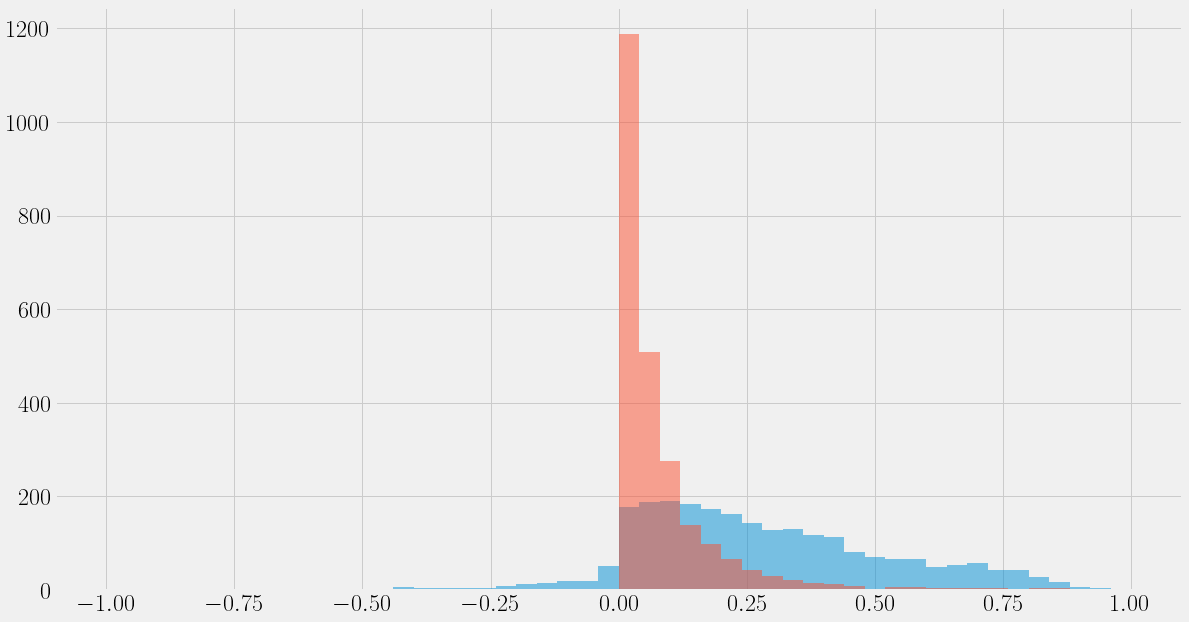

In [38]:
# sample some crawling trajectories and use them to compute estimators with higher confidencec
N = 1000
rg = np.random.default_rng(0)
# crawling_sample = rg.choice(clean_subset['crawling'], N, replace=False)
crawling_sample = clean_subset['crawling']
qdist = []
adist = []
for idx in crawling_sample:
    u =  all_ltrs[idx].get_step_velocity()
    q_estimate, a_estimate = mle(u[1:],u[:-1])
    qdist.append(q_estimate)
    adist.append(a_estimate)
qdist, adist = np.array(qdist), np.array(adist) 
hstyle = {'alpha':0.5}
ax = plt.gca()
ax.hist(qdist, bins=50, range=(-1,1), **hstyle)
ax.hist(adist, bins=50, range=(-1,1), **hstyle)
plt.show()
 

 interestingly it would appear that the long distance (q,a) behaviour
 varies greatly within the crawling set.
 it would be useful to plot some examples to see the difference by eye

In [39]:
# try removing short trajectories (i.e less than 10 data points)
# I don't actually think this will change much but its worth checking
data_threshold = 20
above_threshold_idx = data_size[crawling_sample] >= data_threshold
print('{} crawling, {} after threshold'.format(crawling_sample.size,
    np.count_nonzero(above_threshold_idx)))

# low_data_idx = np.argwhere(data_size < data_threshold).ravel()

2451 crawling, 2121 after threshold


In [40]:
if detail: # and indeed it doesn't affect the distribution
    ax = plt.gca()
    ax.hist(qdist[above_threshold_idx], bins=50, range=(-1,1), **hstyle)
    ax.hist(adist[above_threshold_idx], bins=50, range=(-1,1), **hstyle)
    plt.show()


In [41]:
# ---------------------------------------------------------------------------------
# boxplot and correlations 
# - at first we plot the boxplot of the per track correlations
#   now we would like to check the correlation of track (step) mean velocity 
#   and parameter estimates 
step_crawling_speed = step_mean_speed[crawling_sample]
def compute_track_corr(qdist, adist, step_crawling_speed):
    track_corr = {}
    track_corr['qa'] = np.corrcoef(qdist, adist)[0,1]
    track_corr['qu'] = np.corrcoef(step_crawling_speed, qdist)[0,1]
    track_corr['au'] = np.corrcoef(step_crawling_speed, adist)[0,1]
    return track_corr
track_corr = compute_track_corr(qdist, adist, step_crawling_speed)
import json
print('data size', crawling_sample.size)
print(json.dumps(track_corr, indent=1))
# qa,qu are both small but au is large. extremely suspect
 

data size 2451
{
 "qa": -0.020986756011761337,
 "qu": 0.03876433672765383,
 "au": 0.45456834026349746
}


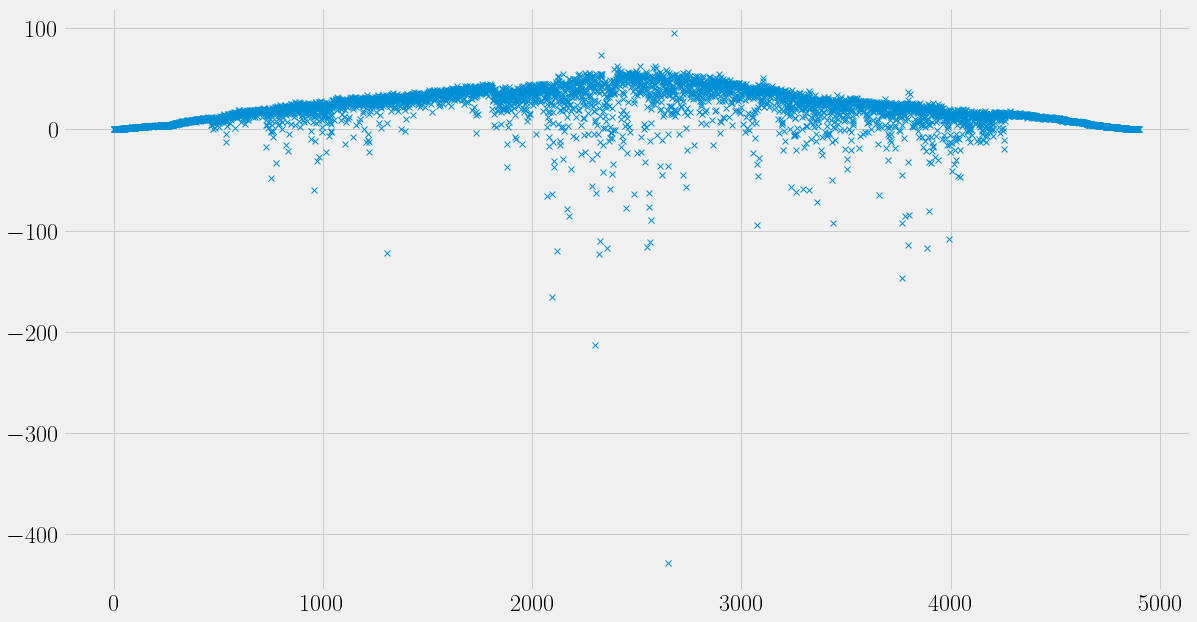

In [42]:
# plot the correlation function
corr = np.correlate(qdist,adist,mode='full')
markerkw = {'linestyle':'none','marker':'x'}
plt.plot(corr, **markerkw)
plt.show()
# we see it is mostly positive but with large negative outliers
# could these outliers just be the low data tracks?

using data threshold 10 steps
data size after threshold 2322, (129 removed)


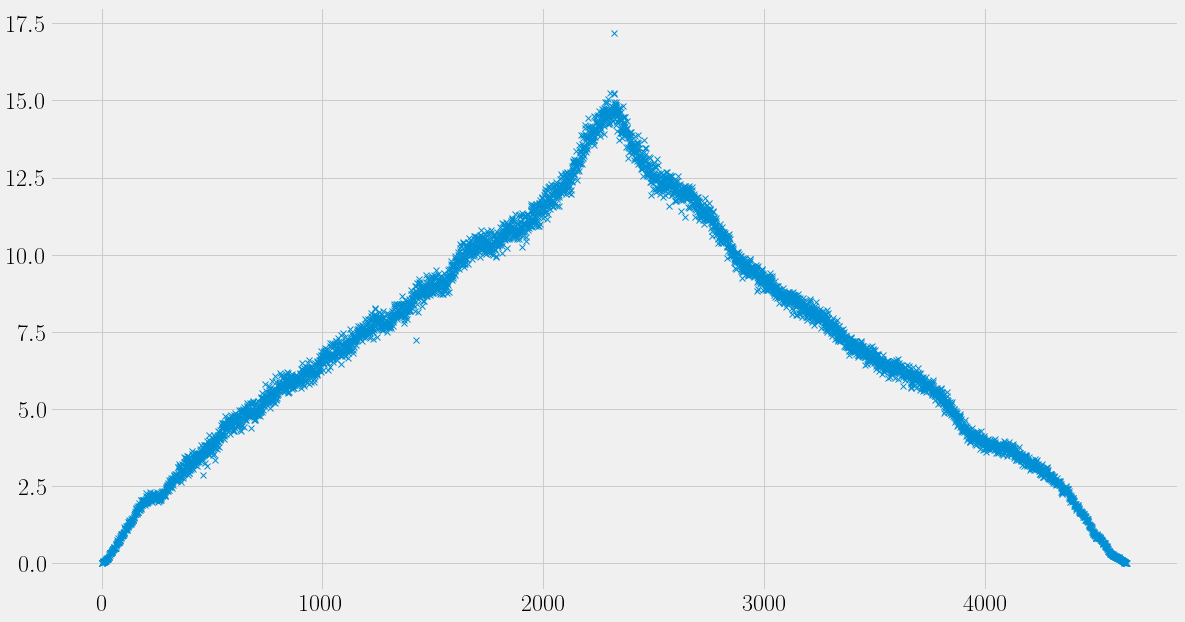

In [43]:
data_threshold = 10
above_threshold_idx = data_size[crawling_sample] >= data_threshold
print('using data threshold {} steps'.format(data_threshold))
print('data size after threshold {}, ({} removed)'.format(
    np.count_nonzero(above_threshold_idx), np.count_nonzero(~above_threshold_idx)))
arr = qdist[above_threshold_idx]
var = step_crawling_speed[above_threshold_idx]
corr = np.correlate(arr,var,mode='full')
plt.plot(corr, **markerkw)
plt.show()
# and indeed they are the low data outliers
# keep in mind that the low data outliers are also the low velocity/motility outliers

In [44]:
cleaned_track_corr = compute_track_corr(qdist[above_threshold_idx], 
    adist[above_threshold_idx], step_crawling_speed[above_threshold_idx])
print(json.dumps(cleaned_track_corr, indent=1))
# q,a parameters for the tracks and anti-correlated and 
# a,u are positively correlated, just like the mean correlations for each track
# but now we see that for long distance behvaiour and without the non-motile
# outliers, persistance is correlated with velocity



{
 "qa": -0.22053290875249318,
 "qu": 0.22856908297429232,
 "au": 0.4437914141628387
}


<ipython-input-45-6be20410dd34>:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


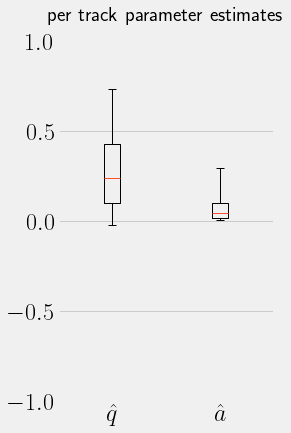

In [45]:
# long distance (step) q, a boxplot
fig = plt.figure(figsize=(3,5))
ax = fig.add_axes([0,0,1,1])
kw = {'whis':(5,95), 'showfliers':False}
ax.boxplot([qdist, adist], **kw)
ax.set_xticklabels([r'$\hat{q}$', r'$\hat{a}$'])
ax.set_ylim((-1,1))
ax.set_title('per track parameter estimates', pad=20)
ax.grid(axis='x')
# for d in ['top', 'bottom', 'right', 'left']:
#     ax.spines[d].set_visible(False)
fig.tight_layout()
plt.show()

# it would be useful to compare this with kMSD


In [46]:
# combine samples and use estimator method
# this gives us (q,a) estimates if we consider all fanjin trajectories as 
# samples of the same motion.
# since the q estimates for the data set are quite spread it makes more sense 
# to compare the weighted mean (?), using the q estimate for each sample
# as an independent trajectory.
sample_up = []
sample_ut = []
for idx in crawling_sample:
    u = all_ltrs[idx].get_step_velocity()
    u_t = u[1:]
    u_p = u[:-1]
    sample_ut.append(u_t)
    sample_up.append(u_p)

totalut = np.concatenate(sample_ut)
totalup = np.concatenate(sample_up)
print('total data length', totalup.shape[0])
sample = np.array(range(totalut.shape[0]))
sample_qhat, sample_ahat = mle(totalut, totalup, sample=sample)

total data length 234160


In [47]:
print(sample_qhat, sample_ahat)

# CI
info_qq, info_aa = fisher_information(totalut, totalup, sample_qhat, sample_ahat)
err = 1.96/np.sqrt(info_qq)
print('q = {} +/- {}'.format(sample_qhat, err))
err = 1.96/np.sqrt(info_aa)
print('a = {} +/- {}'.format(sample_ahat, err))


0.2143494599134273 0.1875852523725484
q = 0.2143494599134273 +/- 0.0026385071759705693
a = 0.1875852523725484 +/- 0.00037989882403605054


In [48]:
# It makes more sense to compute central tendency of the independent trajectories
step_track_size = data_size[crawling_sample]
# weighted mean 
swmean = {}
swmean['q'] = np.sum(step_track_size*qdist)/np.sum(step_track_size)
swmean['a'] = np.sum(step_track_size*adist)/np.sum(step_track_size)
swmean['u'] = np.sum(step_track_size*step_crawling_speed)/np.sum(step_track_size)
#  I guess mean/median is a more appropriate measure actually
# we want to know if we pick a track from the set randomly, what
# central value are our parameters centered around.
smedian = {}
smedian['q'] = np.median(qdist)
smedian['a'] = np.median(adist)
smedian['u'] = np.median(step_crawling_speed)
print('median values for crawling set')
print(json.dumps(smedian, indent=1))



median values for crawling set
{
 "q": 0.2380300568712687,
 "a": 0.0425800188374819,
 "u": 0.01602813792451482
}


 Where we see that our crawling test trajectory really is an outlier
 since it has q ~ 0.7 rather than the central value q ~ 0.3

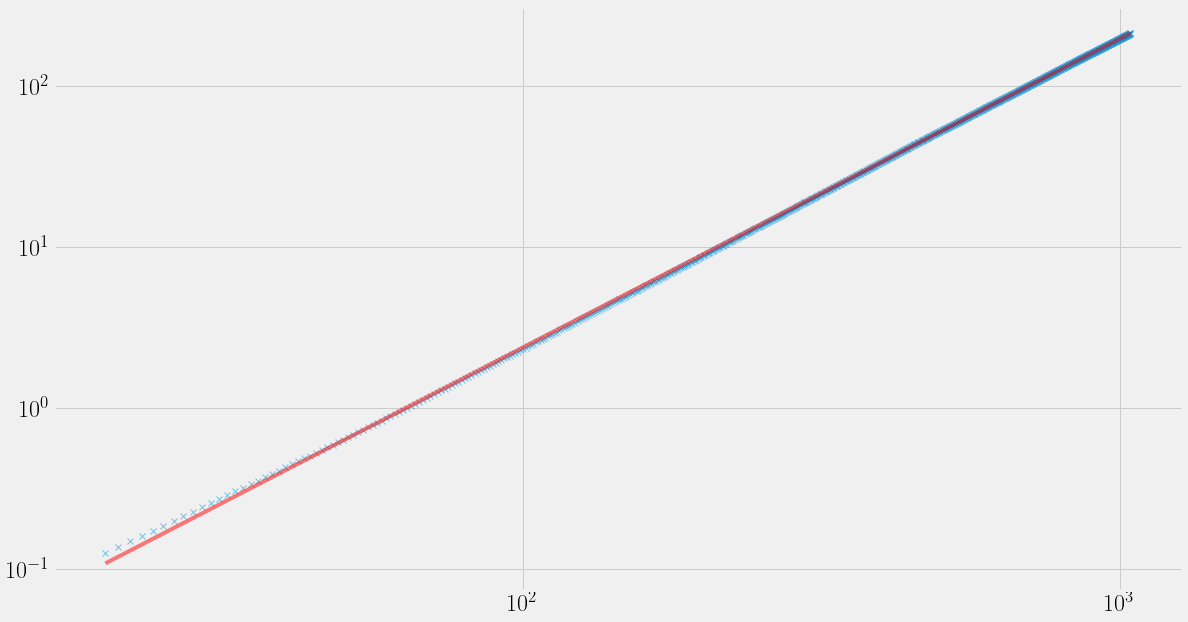

[[ 4.25402108e-07 -2.56237383e-06]
 [-2.56237383e-06  1.57286780e-05]]
estimated standard deviation of parameters (kmsd, _)
[0.00065223 0.00396594]


In [49]:
# lets compare to kMSD
# -----------------------------------------------------------------------
import astrack
# first for our candidate track
p, cov, scaling, msd_n = astrack.kmsd_one(fctrack)
one_kmsd, intercept = p
plt.loglog(scaling, msd_n, marker='x', linestyle='none', alpha=0.5)

def make_reverse(kmsd, intercept):
    def reverse(x):
        return np.exp(kmsd*np.log(x) + intercept)
    return reverse
reverse = make_reverse(one_kmsd, intercept)

fit = np.array([reverse(x) for x in scaling])
overlay = {'alpha':0.5, 'linewidth':4, 'color':'r'}
plt.loglog(scaling, fit, **overlay)
plt.show()
# we can request np.polyfit to return the covariance matrix 
print(cov)
print('estimated standard deviation of parameters (kmsd, _)')
pstd = np.sqrt(np.diag(cov))
print(pstd)
# where the diagonal elements are the variances of the parameters
# 

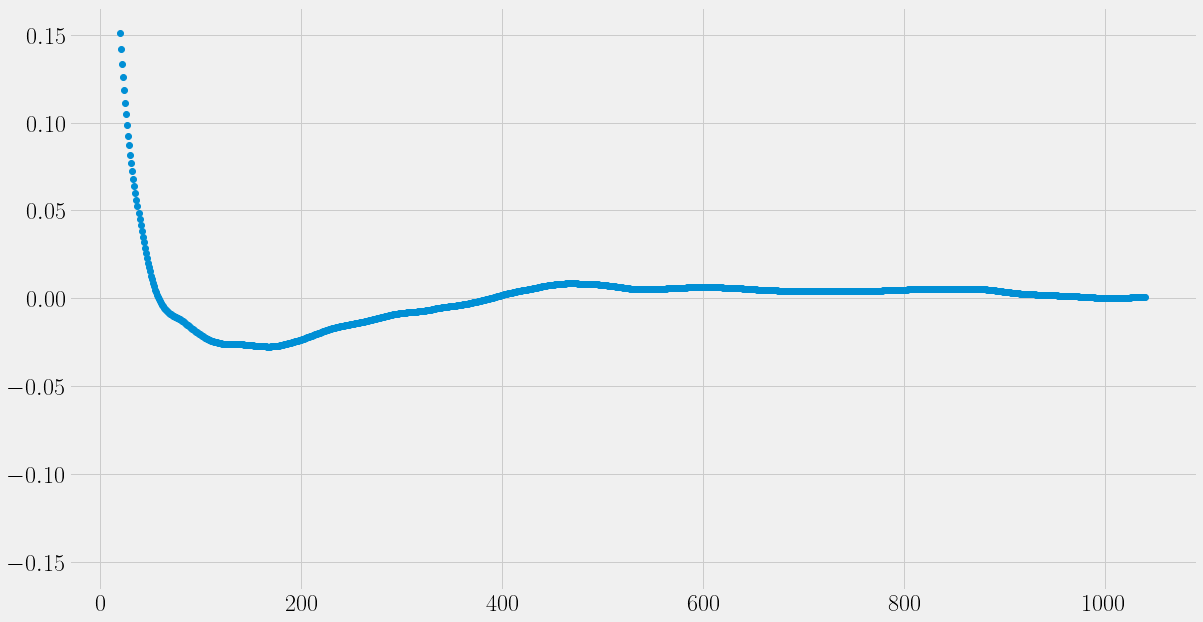

In [50]:
# so we anticipate the residuals will be gaussian distributed?
# residual = msd_n - fit
yt = one_kmsd*np.log(scaling) + intercept
residual = np.log(msd_n) - yt
max_res = np.abs(residual).max() * 1.1
rss = np.sum(residual**2)
ax = plt.gca()
ax.plot(scaling, residual, linestyle='none', marker='o')
ax.set_ylim((-max_res,max_res))
plt.show()

In [51]:
# As expected the linearity assumption is violated and the residuals are 
# not gaussian distributed. Rather than attempt to construct a
# confidence interval we will note the estimated std of the slope parameter
print('std(kMSD) = {:.6f}'.format(pstd[0]))
# and the sum of square residuals
print('RSS = ', rss)
# small numbers indicate a good quality of fit, which means the linear
# model is a good approximation


std(kMSD) = 0.000652
RSS =  0.30632952469936586


no. steps quartiles [9, 36, 76, 145, 336]
mean step time quartiles [1.01541140806731, 3.5510691008246873, 6.739999999999999, 16.610871848739496, 87.31435064935056]
/home/dan/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dan/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


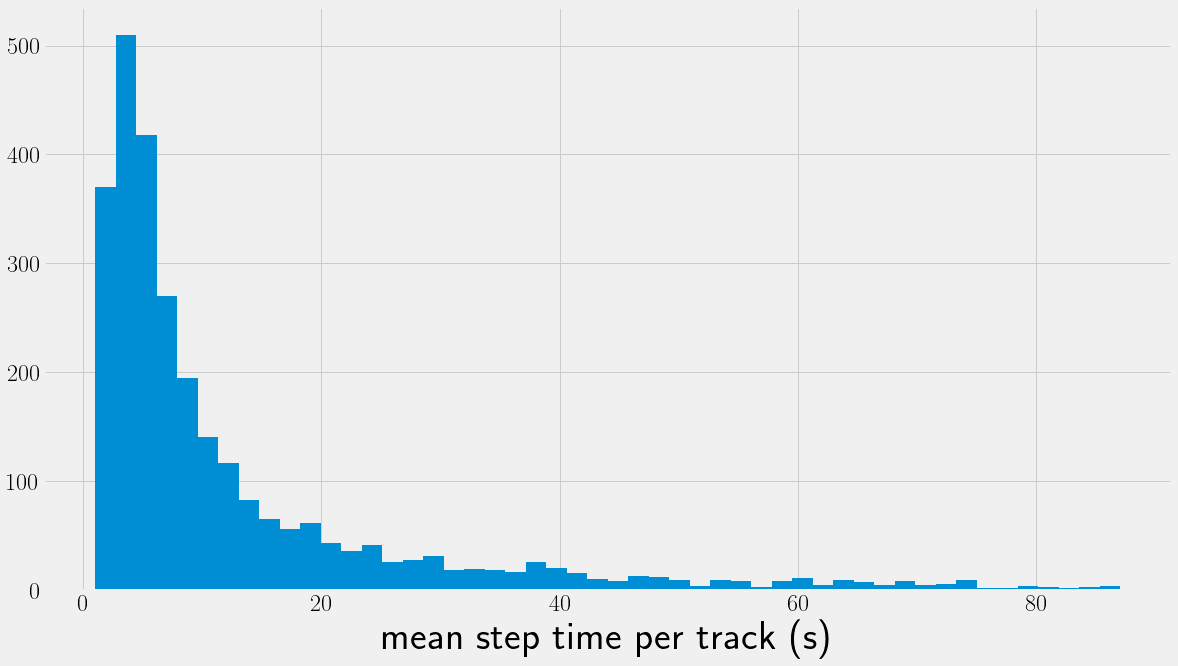

median average step time of our crawling population 6.74000s
which is 67 timesteps at 0.1 second resolution
min track duration 667


In [52]:
# what about the spread of kMSD and std(KMSD)
# before we do anything, what is the distribution of no. steps in linearised tracks
nsteps = np.array([len(ltr.step_idx) for ltr in all_ltrs], dtype=int)
# and what is the average time of the steps
tsize = np.array([np.mean(np.diff(ltr.step_idx) * matdef.TIMESTEP) for  ltr
    in all_ltrs])
# ^can contain np.nan if len(step_idx) < 2
valid = ~np.isnan(tsize)

quantiles = [x/100. for x in [5,25,50,75,95]]
distrib = [int(np.quantile(nsteps, quant)) for quant in quantiles]
tdistrib = [np.quantile(tsize[valid], quant) for quant in quantiles]
print('no. steps quartiles', distrib)
print('mean step time quartiles', tdistrib)

t_tsize = twutils.trim(tsize[valid])
ax = plt.gca()
ax.hist(t_tsize,bins=50)
ax.set_xlabel('mean step time per track (s)')
plt.show()

median_tsize = np.median(tsize[valid])
print('median average step time of our crawling population {:.5f}s'.format(
    median_tsize))
median_sis = int(median_tsize/matdef.TIMESTEP)
short_time_threshold = median_sis
print('which is {} timesteps at {} second resolution'.format(short_time_threshold,
    matdef.TIMESTEP))
# i'm going to take this timescale as proxy for the short time (noisy) behaviour
#  of the trajectory and demand that tracks be longer than this to calculate kMSD
track_duration = np.array([tr['time'].size for tr in all_trs])
print('min track duration', track_duration.min())
short_time_outlier = track_duration<short_time_threshold
# so the min track size seems to be long enough to estimate kMSD


In [53]:
# kmsd analysis file IO
import pickle
kmsd_target_dir = os.path.join(pili.root, '../fanjin/working_copy/analysis')
form = 'kmsd.pkl'

def naming():
    return os.path.normpath(os.path.join(kmsd_target_dir, form))

def save_kmsd(kmsdd):
    target = naming()
    print('saving to ', target)
    with open(target, 'wb') as fp:
        pickle.dump(kmsdd, fp)

def load_kmsd():
    target = naming()
    print('loading from ', target)
    with open(target, 'rb') as fp:
        kmsdd = pickle.load(fp)
    return kmsdd


In [54]:

# kmsd calculation is way too slow 
# we need to pickle this and load it here

N = len(all_trs)
debug_sample  = np.array(range(10))
sample = debug_sample
sample = np.arange(N) 

# could use structured array
if expensive:
    kmsdd = {}
    kmsdd['estimate'] = np.empty(N)
    kmsdd['std'] = np.empty(N) 
    for i, tr in tqdm(enumerate(all_trs[sample])):
        result = astrack.kmsd_one(tr)
        if result is None:
            for k in kmsdd.keys():
                kmsdd[k][i] = np.nan
            continue
        p, cov, _, _ = result
        kmsd, _ = p
        stdkmsd, _stdinter = np.sqrt(np.diag(cov))
        kmsdd['estimate'][i] = kmsd
        kmsdd['std'][i] = stdkmsd

    print()
    save_kmsd(kmsdd)


In [55]:
loaded = load_kmsd()


loading from  /home/dan/usb_twitching/fanjin/working_copy/analysis/kmsd.pkl


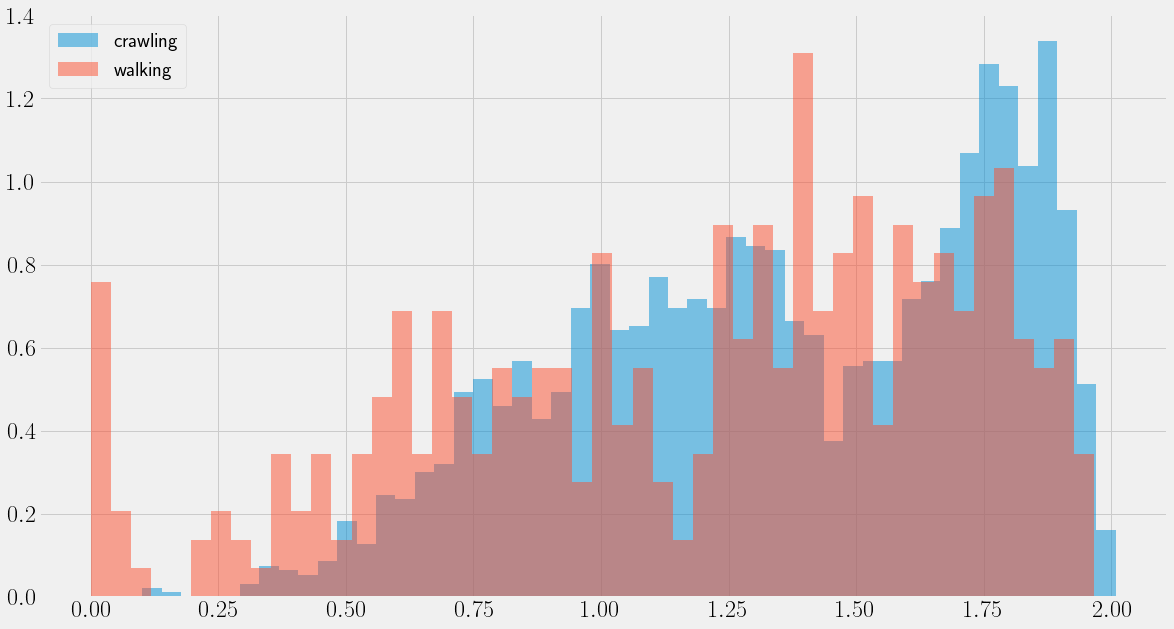

In [56]:
kmsd = loaded['estimate']
valid = ~np.isnan(kmsd)
kmsd[~valid] = 0.0
ax = plt.gca()
hstyle = {'alpha':0.5, 'density':True}
ax.hist(kmsd[crawling_sample], bins=50, label='crawling', **hstyle)
ax.hist(kmsd[clean_subset['walking']], bins=50, label='walking', **hstyle)
ax.legend()
plt.show()

2.0082908635784795
1.3582103371289522 1.1958111545721841


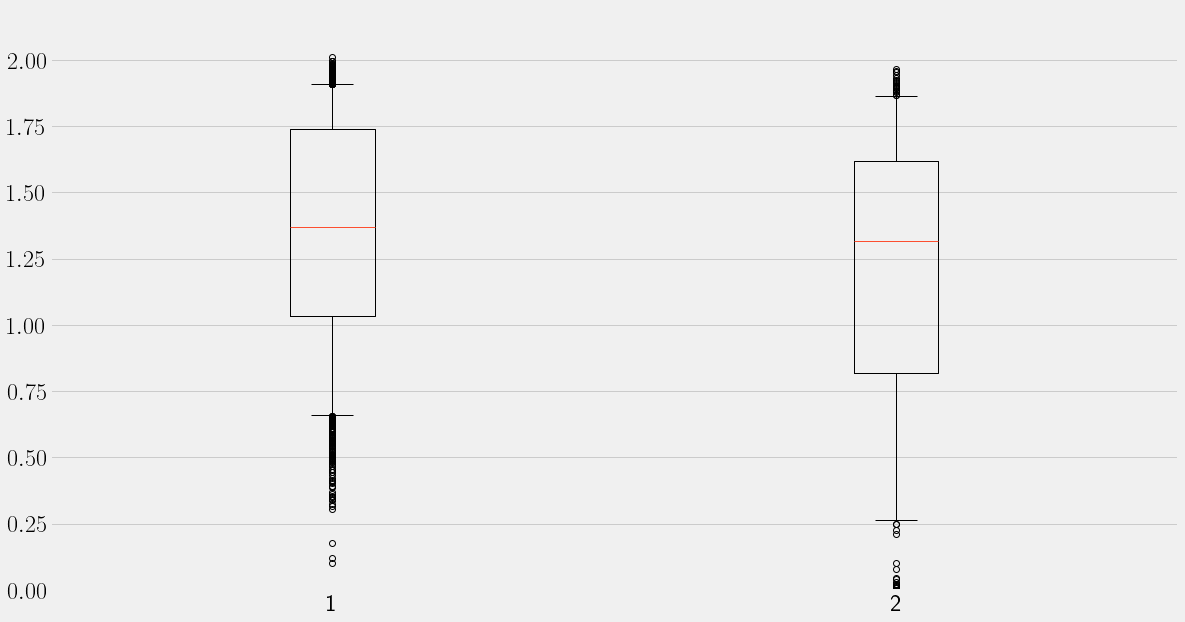

In [57]:
ax = plt.gca()
print(np.nanmax(kmsd))
kw = {'whis':(5,95), 'showfliers':True}
ax.boxplot([kmsd[crawling_sample], kmsd[clean_subset['walking']]], **kw)
print(np.mean(kmsd[crawling_sample]), np.mean(kmsd[clean_subset['walking']]) )
ax.set_ylim((0,1.1*2))
ax.grid(axis='x')
# for d in ['top', 'bottom', 'right', 'left']:
#     ax.spines[d].set_visible(False)
plt.show()
ax.clear()


In [58]:

# simulated data
import rtw
import stats
target = "../../run/two_parameter_model/two_parameters/"
dc = rtw.DataCube(target)
qcube = dc.get_local_array( rtw._make_get("q.estimate") )
acube = dc.get_local_array( rtw._make_get("a.estimate") )


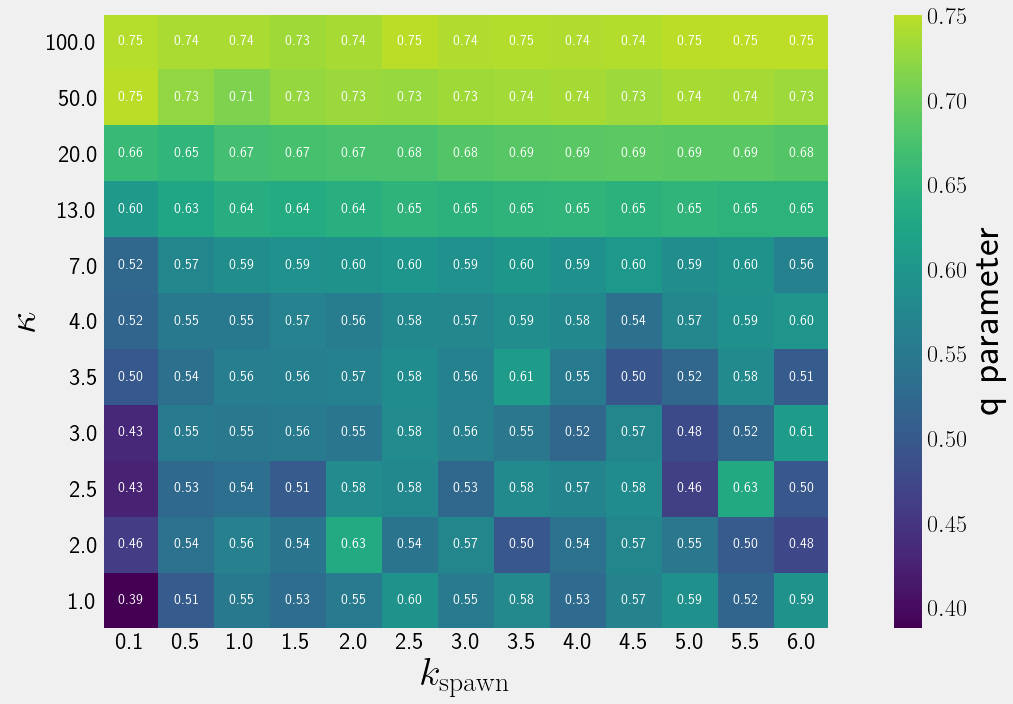

In [59]:
plt.style.use(plotutils.get_style('image'))
ax = plt.gca()
rtw._data_image(ax, dc, qcube, c_label='q parameter', 
    annotate = True, annotate_form='{:3.2f}', space='index',
    use_lognorm=False, C_an=None
    )
plt.show()

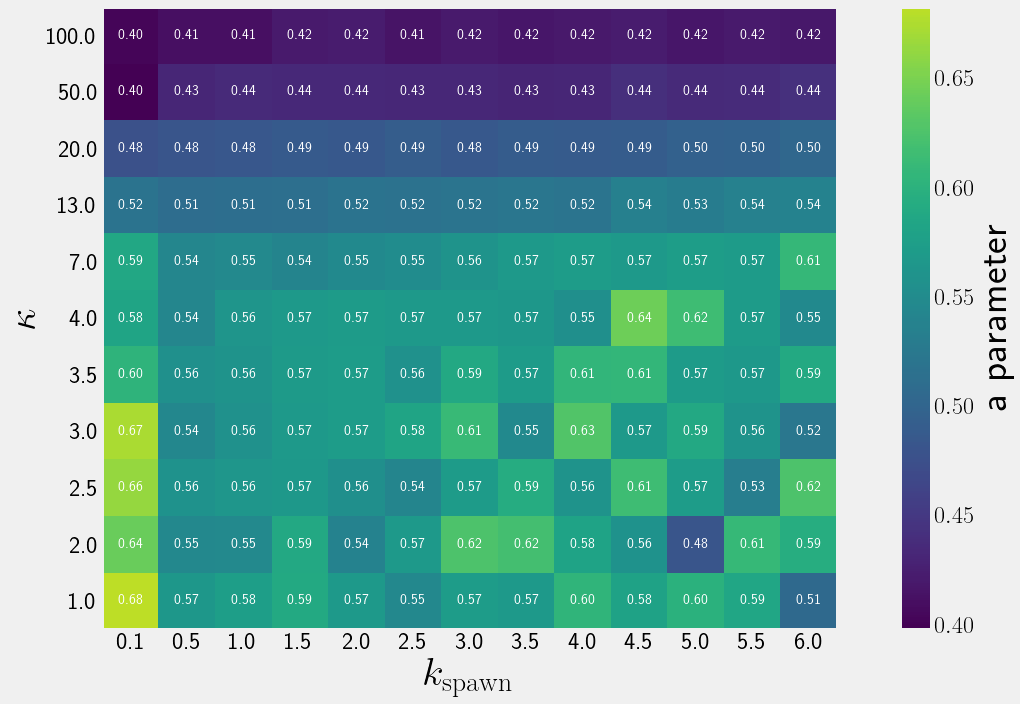

In [60]:
ax = plt.gca()
rtw._data_image(ax, dc, acube, c_label='a parameter', 
    annotate = True, annotate_form='{:3.2f}', space='index',
    use_lognorm=False, C_an=None
    )
plt.show()



